In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import LDA
import numpy as np
import pandas as pd

In [ ]:
app_train = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/application_train.csv",inferSchema=True)
prev_app = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/previous_application.csv",inferSchema=True)
pos_cash = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/POS_CASH_balance.csv",inferSchema=True)
install_payments = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/installments_payments.csv",inferSchema=True)
credit_bal = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/credit_card_balance.csv",inferSchema=True)
bureau_bal = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/bureau_balance.csv",inferSchema=True)
bureau = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/bureau.csv",inferSchema=True)

In [ ]:
prev_app.createOrReplaceTempView("prev_app")
app_train.createOrReplaceTempView("app_train")
bureau.createOrReplaceTempView("bureau")
pos_cash.createOrReplaceTempView("pos_cash")
install_payments.createOrReplaceTempView("install_payments")
credit_bal.createOrReplaceTempView("credit_bal")
check = spark.sql('''select SK_ID_CURR from app_train''')
check_1 = spark.sql('''select distinct SK_ID_CURR from prev_app''')



In [ ]:
pos_sk = spark.sql('''select distinct SK_ID_CURR from pos_cash''')
app_train_sk = spark.sql('''select SK_ID_CURR from app_train''')
prev_sk = spark.sql('''select SK_ID_CURR from prev_app''')
credit_sk = spark.sql('''select SK_ID_CURR from credit_bal''')
install_sk = spark.sql('''select SK_ID_CURR from install_payments''')
bureau_sk = spark.sql('''select SK_ID_CURR from bureau''')


In [ ]:
prev_app_train = app_train_sk.intersect(prev_sk)

In [ ]:
prev_app_pos = prev_app_train.intersect(pos_sk)

In [ ]:
prev_app_pos_credit = prev_app_pos.intersect(credit_sk)

In [ ]:
prev_app_pos_credit_install_sk = prev_app_pos_credit.intersect(install_sk)

In [ ]:
prev_app_pos_credit_install_sk_bureau = prev_app_pos_credit_install_sk.intersect(bureau_sk)

In [ ]:
prev_app_pos_credit_install_sk_bureau.count()

72793

In [ ]:
prev_app_pos_credit_install_sk_bureau = prev_app_pos_credit_install_sk_bureau.withColumnRenamed('SK_ID_CURR','id')

In [ ]:
prev_app_pos_credit_install_sk_bureau.createOrReplaceTempView("prev_app_pos_credit_install_sk_bureau")


In [ ]:
# app_train = app_train.withColumnRenamed('SK_ID_CURR','id')

In [ ]:
app_train_1=spark.sql('''SELECT *
FROM app_train
RIGHT JOIN prev_app_pos_credit_install_sk_bureau
ON app_train.SK_ID_CURR = prev_app_pos_credit_install_sk_bureau.id; ''')

In [ ]:
app_train_1.createOrReplaceTempView("app_train_1")
# spark.sql('''select * from app_train_1 where app_train_1.SK_ID_CURR='100001' ''').show()

In [ ]:
prev_train=spark.sql('''SELECT *
FROM prev_app
RIGHT JOIN prev_app_pos_credit_install_sk_bureau
ON prev_app.SK_ID_CURR = prev_app_pos_credit_install_sk_bureau.id; ''')

In [ ]:
pos_cash_train=spark.sql('''SELECT *
FROM pos_cash
RIGHT JOIN prev_app_pos_credit_install_sk_bureau
ON pos_cash.SK_ID_CURR = prev_app_pos_credit_install_sk_bureau.id; ''')

In [ ]:
credit_bal_train=spark.sql('''SELECT *
FROM credit_bal
RIGHT JOIN prev_app_pos_credit_install_sk_bureau
ON credit_bal.SK_ID_CURR = prev_app_pos_credit_install_sk_bureau.id; ''')

In [ ]:
bureau_train =spark.sql('''SELECT *
FROM bureau
RIGHT JOIN prev_app_pos_credit_install_sk_bureau
ON bureau.SK_ID_CURR = prev_app_pos_credit_install_sk_bureau.id; ''')

In [ ]:
# pos_cash_train.first()

In [ ]:
# credit_bal_train.first()
from pyspark.sql.functions import col,count,isnan,when
rd = app_train_1.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_1.columns])

In [ ]:
r=[]
for i in range(len(app_train_1.columns)):
  # print(rd[i],rd.collect()[0][i]/app_train.count())
  # r = rd.collect()[0][i]/app_train.count()>0.5
  if(rd.collect()[0][i]/72793>0.5):
    r.append(rd.columns[i])

In [ ]:
len(r)

30

In [ ]:
for i in r:
  app_train_1 = app_train_1.drop(i)

In [ ]:
len(app_train_1.columns)

93

In [ ]:
cat_cols = [item[0] for item in app_train_1.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in app_train_1.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

15  categorical features
77  numerical features


In [ ]:
from pyspark.ml.feature import Imputer
for i in num_cols:
  imputer = Imputer(
      inputCols=[], 
      outputCols=[]
      ).setStrategy("mean")

In [ ]:
model = imputer.fit(app_train_1)
app_train_imputed = model.transform(app_train_1)


In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_1 = app_train_1.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_1.columns])
for i in range(len(app_train_1.columns)):
  if(rd_1.collect()[0][i]>0):
    print(rd_1.columns[i])

AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
OCCUPATION_TYPE
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
YEARS_BEGINEXPLUATATION_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
YEARS_BEGINEXPLUATATION_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
LIVINGAREA_MODE
APARTMENTS_MEDI
YEARS_BEGINEXPLUATATION_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
LIVINGAREA_MEDI
HOUSETYPE_MODE
TOTALAREA_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE


In [ ]:
miss = ['AMT_ANNUITY',
'AMT_GOODS_PRICE',
'NAME_TYPE_SUITE',
'OCCUPATION_TYPE',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
'APARTMENTS_AVG',
'YEARS_BEGINEXPLUATATION_AVG',
'ENTRANCES_AVG',
'FLOORSMAX_AVG',
'LIVINGAREA_AVG',
'APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'LIVINGAREA_MODE',
'APARTMENTS_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI',
'ENTRANCES_MEDI',
'FLOORSMAX_MEDI',
'LIVINGAREA_MEDI',
'HOUSETYPE_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'EMERGENCYSTATE_MODE',
'OBS_30_CNT_SOCIAL_CIRCLE',
'DEF_30_CNT_SOCIAL_CIRCLE',
'OBS_60_CNT_SOCIAL_CIRCLE',
'DEF_60_CNT_SOCIAL_CIRCLE']

In [ ]:
cat_col_mis = list(set(cat_cols).intersection(miss))

In [ ]:
num_c0l_miss = list(set(num_cols).intersection(miss))

In [ ]:
num_c0l_miss

['ENTRANCES_MODE',
 'EXT_SOURCE_2',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'LIVINGAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_3',
 'APARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MODE']

In [ ]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
df_Nomiss=app_train_imputed.na.drop()
for x in cat_col_mis:                  
  mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
  print(x, mode) #print name of columns and it's most categories 
  app_train_imputed = app_train_imputed.na.fill({x:mode})

NAME_TYPE_SUITE Unaccompanied
WALLSMATERIAL_MODE Panel
OCCUPATION_TYPE Laborers
EMERGENCYSTATE_MODE No
HOUSETYPE_MODE block of flats


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
      inputCols=['YEARS_BEGINEXPLUATATION_AVG',
 'APARTMENTS_MEDI',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'APARTMENTS_AVG',
 'ENTRANCES_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'TOTALAREA_MODE',
 'FLOORSMAX_AVG',
 'EXT_SOURCE_3',
 'ENTRANCES_MODE',
 'ENTRANCES_MEDI',
 'AMT_GOODS_PRICE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'AMT_ANNUITY'], 
      outputCols=['YEARS_BEGINEXPLUATATION_AVG',
 'APARTMENTS_MEDI',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'APARTMENTS_AVG',
 'ENTRANCES_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'TOTALAREA_MODE',
 'FLOORSMAX_AVG',
 'EXT_SOURCE_3',
 'ENTRANCES_MODE',
 'ENTRANCES_MEDI',
 'AMT_GOODS_PRICE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'AMT_ANNUITY']
      ).setStrategy("mean")

In [ ]:
model = imputer.fit(app_train_imputed)
app_train_imputed = model.transform(app_train_imputed)

In [ ]:
app_train_imputed.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+---------------------------+-------------------+-------------------+-------------------+-------------------+----------------------------+-------------------+-------------------+------------------+-------------------+------

In [ ]:
app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+--------------+---------------------------+-------------+-------------+--------------+---------------+----------------------------+--------------+--------------+---------------+---------------+----------------------------+--------------+--------------+---------------

In [ ]:
app_train_imputed = app_train_imputed.drop('id')

In [ ]:
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE'],outputCols=['NAME_CONTRACT_TYPE_indexed',
 'CODE_GENDER_indexed',
 'FLAG_OWN_CAR_indexed',
 'FLAG_OWN_REALTY_indexed',
 'NAME_TYPE_SUITE_indexed',
 'NAME_INCOME_TYPE_indexed',
 'NAME_EDUCATION_TYPE_indexed',
 'NAME_FAMILY_STATUS_indexed',
 'NAME_HOUSING_TYPE_indexed',
 'OCCUPATION_TYPE_indexed',
 'WEEKDAY_APPR_PROCESS_START_indexed',
 'ORGANIZATION_TYPE_indexed',
 'HOUSETYPE_MODE_indexed',
 'WALLSMATERIAL_MODE_indexed',
 'EMERGENCYSTATE_MODE'+'_indexed'])


In [ ]:
app_train_indexer = indexer.fit(app_train_imputed).transform(app_train_imputed)

In [ ]:
app_train_indexer.show(2)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+-------------------+------------------+-------------------+---------------------------+-------------------+-------------------+-------------------+-------------------+----------------------------+-------------------+-------------------+------------------+-------------------+---------------

In [ ]:
app_train_indexer = app_train_indexer.drop('NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE')

In [ ]:
encoder = OneHotEncoder(inputCols=['NAME_CONTRACT_TYPE_indexed',
 'CODE_GENDER_indexed',
 'FLAG_OWN_CAR_indexed',
 'FLAG_OWN_REALTY_indexed',
 'NAME_TYPE_SUITE_indexed',
 'NAME_INCOME_TYPE_indexed',
 'NAME_EDUCATION_TYPE_indexed',
 'NAME_FAMILY_STATUS_indexed',
 'NAME_HOUSING_TYPE_indexed',
 'OCCUPATION_TYPE_indexed',
 'WEEKDAY_APPR_PROCESS_START_indexed',
 'ORGANIZATION_TYPE_indexed',
 'HOUSETYPE_MODE_indexed',
 'WALLSMATERIAL_MODE_indexed',
 'EMERGENCYSTATE_MODE_indexed'],
                                 outputCols=['NAME_CONTRACT_TYPE_en',
 'CODE_GENDER_en',
 'FLAG_OWN_CAR_en',
 'FLAG_OWN_REALTY_en',
 'NAME_TYPE_SUITE_en',
 'NAME_INCOME_TYPE_en',
 'NAME_EDUCATION_TYPE_en',
 'NAME_FAMILY_STATUS_en',
 'NAME_HOUSING_TYPE_en',
 'OCCUPATION_TYPE_en',
 'WEEKDAY_APPR_PROCESS_START_en',
 'ORGANIZATION_TYPE_en',
 'HOUSETYPE_MODE_en',
 'WALLSMATERIAL_MODE_en',
 'EMERGENCYSTATE_MODE_en'])

In [ ]:
app_train_encoded = encoder.fit(app_train_indexer).transform(app_train_indexer)

In [ ]:
app_train_encoded.show()

+----------+------+------------+----------------+----------+-----------+---------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+--------------------+---------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+-------------------+---------------------------+-------------------+-------------------+-------------------+-------------------+----------------------------+-------------------+-------------------+------------------+-------------------+----------------------------+-------------------+-------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+--------------------

In [ ]:
app_train_encoded.columns

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT

In [ ]:
app_train_encoded_1 = app_train_encoded.drop('FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL','HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY','YEARS_BEGINEXPLUATATION_MODE','YEARS_BEGINEXPLUATATION_MEDI','APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE','AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',)

In [ ]:
# from pyspark.sql.functions import when
# ratio = 0.91
# def weight_balance(labels):
#     return when(labels == 1, ratio).otherwise(1*(1-ratio))
# app_train_encoded_1 = app_train_encoded_1.withColumn('weights', weight_balance(col('TARGET')))

Changing the secound file Previous data 

In [ ]:
cat_cols_prev = [item[0] for item in prev_train.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols_prev)) + '  categorical features')
num_cols_prev = [item[0] for item in prev_train.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols_prev)) + '  numerical features')

16  categorical features
21  numerical features


In [ ]:
num_cols_prev

['SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'id']

In [ ]:
cat_cols_prev

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
prev_train.createOrReplaceTempView("prev_train")
prev_num = spark.sql('''select AMT_ANNUITY,
 AMT_APPLICATION,
 AMT_CREDIT,
 AMT_DOWN_PAYMENT,
 AMT_GOODS_PRICE,
 HOUR_APPR_PROCESS_START,
 NFLAG_LAST_APPL_IN_DAY,
 RATE_DOWN_PAYMENT,
 RATE_INTEREST_PRIMARY,
 RATE_INTEREST_PRIVILEGED,
 DAYS_DECISION,
 SELLERPLACE_AREA,
 CNT_PAYMENT,
 DAYS_FIRST_DRAWING,
 DAYS_FIRST_DUE,
 DAYS_LAST_DUE_1ST_VERSION,
 DAYS_LAST_DUE,
 DAYS_TERMINATION,
 NFLAG_INSURED_ON_APPROVAL,
 id from prev_train''')

In [ ]:
prev_num.show()

+-----------+---------------+----------+----------------+---------------+-----------------------+----------------------+-------------------+---------------------+------------------------+-------------+----------------+-----------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+------+
|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|HOUR_APPR_PROCESS_START|NFLAG_LAST_APPL_IN_DAY|  RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|DAYS_DECISION|SELLERPLACE_AREA|CNT_PAYMENT|DAYS_FIRST_DRAWING|DAYS_FIRST_DUE|DAYS_LAST_DUE_1ST_VERSION|DAYS_LAST_DUE|DAYS_TERMINATION|NFLAG_INSURED_ON_APPROVAL|    id|
+-----------+---------------+----------+----------------+---------------+-----------------------+----------------------+-------------------+---------------------+------------------------+-------------+----------------+-----------+------------------+--------------+-------------------------+

In [ ]:
prev_num = prev_num.groupBy('id').mean()

In [ ]:
prev_num.columns

['id',
 'avg(AMT_ANNUITY)',
 'avg(AMT_APPLICATION)',
 'avg(AMT_CREDIT)',
 'avg(AMT_DOWN_PAYMENT)',
 'avg(AMT_GOODS_PRICE)',
 'avg(HOUR_APPR_PROCESS_START)',
 'avg(NFLAG_LAST_APPL_IN_DAY)',
 'avg(RATE_DOWN_PAYMENT)',
 'avg(RATE_INTEREST_PRIMARY)',
 'avg(RATE_INTEREST_PRIVILEGED)',
 'avg(DAYS_DECISION)',
 'avg(SELLERPLACE_AREA)',
 'avg(CNT_PAYMENT)',
 'avg(DAYS_FIRST_DRAWING)',
 'avg(DAYS_FIRST_DUE)',
 'avg(DAYS_LAST_DUE_1ST_VERSION)',
 'avg(DAYS_LAST_DUE)',
 'avg(DAYS_TERMINATION)',
 'avg(NFLAG_INSURED_ON_APPROVAL)',
 'avg(id)']

In [ ]:
prev_cat = spark.sql('''select NAME_CONTRACT_TYPE,
 WEEKDAY_APPR_PROCESS_START,
 FLAG_LAST_APPL_PER_CONTRACT,
 NAME_CASH_LOAN_PURPOSE,
 NAME_CONTRACT_STATUS,
 NAME_PAYMENT_TYPE,
 CODE_REJECT_REASON,
 NAME_TYPE_SUITE,
 NAME_CLIENT_TYPE,
 NAME_GOODS_CATEGORY,
 NAME_PORTFOLIO,
 NAME_PRODUCT_TYPE,
 CHANNEL_TYPE,
 NAME_SELLER_INDUSTRY,
 NAME_YIELD_GROUP,
 PRODUCT_COMBINATION,SK_ID_CURR from prev_train''')

In [ ]:
import pyspark.sql.functions as f
prev_cat = prev_cat.groupBy('SK_ID_CURR').agg(f.max('NAME_CONTRACT_TYPE'),
f.max('WEEKDAY_APPR_PROCESS_START'),
f.max('FLAG_LAST_APPL_PER_CONTRACT'),
f.max('NAME_CASH_LOAN_PURPOSE'),
f.max('NAME_CONTRACT_STATUS'),
f.max('NAME_PAYMENT_TYPE'),
f.max('CODE_REJECT_REASON'),
f.max('NAME_TYPE_SUITE'),
 f.max('NAME_CLIENT_TYPE'),
 f.max('NAME_GOODS_CATEGORY'),
 f.max('NAME_PORTFOLIO'),
 f.max('NAME_PRODUCT_TYPE'),
 f.max('CHANNEL_TYPE'),
 f.max('NAME_SELLER_INDUSTRY'),
 f.max('NAME_YIELD_GROUP'),
 f.max('PRODUCT_COMBINATION'))

In [ ]:
prev_cat.show()

+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+-----------------------+--------------------+---------------------+------------------------+-------------------+----------------------+--------------------+-------------------------+---------------------+------------------------+
|SK_ID_CURR|max(NAME_CONTRACT_TYPE)|max(WEEKDAY_APPR_PROCESS_START)|max(FLAG_LAST_APPL_PER_CONTRACT)|max(NAME_CASH_LOAN_PURPOSE)|max(NAME_CONTRACT_STATUS)|max(NAME_PAYMENT_TYPE)|max(CODE_REJECT_REASON)|max(NAME_TYPE_SUITE)|max(NAME_CLIENT_TYPE)|max(NAME_GOODS_CATEGORY)|max(NAME_PORTFOLIO)|max(NAME_PRODUCT_TYPE)|   max(CHANNEL_TYPE)|max(NAME_SELLER_INDUSTRY)|max(NAME_YIELD_GROUP)|max(PRODUCT_COMBINATION)|
+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+------

In [ ]:
prev_cat.createOrReplaceTempView("prev_cat")
prev_num.createOrReplaceTempView("prev_num")
prev_train_up=spark.sql('''SELECT *
FROM prev_num
INNER JOIN prev_cat
ON prev_cat.SK_ID_CURR = prev_num.id; ''')

In [ ]:
prev_train_up.show()

+------+------------------+--------------------+-----------------+---------------------+--------------------+----------------------------+---------------------------+----------------------+--------------------------+-----------------------------+-------------------+---------------------+-----------------+-----------------------+-------------------+------------------------------+------------------+---------------------+------------------------------+--------+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+-----------------------+--------------------+---------------------+------------------------+-------------------+----------------------+--------------------+-------------------------+---------------------+------------------------+
|    id|  avg(AMT_ANNUITY)|avg(AMT_APPLICATION)|  avg(AMT_CREDIT)|avg(AMT_DOWN_PAYMENT)|avg(AMT_GOODS_PRICE)|avg(HOUR_APPR_PROCESS_

In [ ]:
rd_prev = prev_train_up.select([count(when(col(c).isNull(), c)).alias(c) for c in prev_train_up.columns])

In [ ]:
r_prev=[]
for i in range(len(prev_train_up.columns)):
  # print(rd[i],rd.collect()[0][i]/app_train.count())
  # r = rd.collect()[0][i]/app_train.count()>0.5
  if(rd_prev.collect()[0][i]/72793>0.5):
    r_prev.append(rd_prev.columns[i])

In [ ]:
r_prev

['avg(RATE_INTEREST_PRIMARY)', 'avg(RATE_INTEREST_PRIVILEGED)']

In [ ]:
prev_train_up = prev_train_up.drop('avg(RATE_INTEREST_PRIMARY)','avg(RATE_INTEREST_PRIVILEGED)')

In [ ]:
prev_train_up.select([count(when(col(c).isNull(), c)).alias(c) for c in prev_train_up.columns]).show()

+---+----------------+--------------------+---------------+---------------------+--------------------+----------------------------+---------------------------+----------------------+------------------+---------------------+----------------+-----------------------+-------------------+------------------------------+------------------+---------------------+------------------------------+-------+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+-----------------------+--------------------+---------------------+------------------------+-------------------+----------------------+-----------------+-------------------------+---------------------+------------------------+
| id|avg(AMT_ANNUITY)|avg(AMT_APPLICATION)|avg(AMT_CREDIT)|avg(AMT_DOWN_PAYMENT)|avg(AMT_GOODS_PRICE)|avg(HOUR_APPR_PROCESS_START)|avg(NFLAG_LAST_APPL_IN_DAY)|avg(RATE_DOWN_PAYMENT)|avg(DAYS_DECISION)|

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_prev_1 = prev_train_up.select([count(when(col(c).isNull(), c)).alias(c) for c in prev_train_up.columns])
for i in range(len(prev_train_up.columns)):
  if(rd_prev_1.collect()[0][i]>0):
    print(rd_prev_1.columns[i])

avg(AMT_ANNUITY)
avg(AMT_DOWN_PAYMENT)
avg(AMT_GOODS_PRICE)
avg(RATE_DOWN_PAYMENT)
avg(CNT_PAYMENT)
avg(DAYS_FIRST_DRAWING)
avg(DAYS_FIRST_DUE)
avg(DAYS_LAST_DUE_1ST_VERSION)
avg(DAYS_LAST_DUE)
avg(DAYS_TERMINATION)
avg(NFLAG_INSURED_ON_APPROVAL)
max(NAME_TYPE_SUITE)


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
      inputCols=['avg(AMT_ANNUITY)',
'avg(AMT_DOWN_PAYMENT)',
'avg(AMT_GOODS_PRICE)',
'avg(RATE_DOWN_PAYMENT)',
'avg(CNT_PAYMENT)',
'avg(DAYS_FIRST_DRAWING)',
'avg(DAYS_FIRST_DUE)',
'avg(DAYS_LAST_DUE_1ST_VERSION)',
'avg(DAYS_LAST_DUE)',
'avg(DAYS_TERMINATION)',
'avg(NFLAG_INSURED_ON_APPROVAL)'], 
      outputCols=['avg(AMT_ANNUITY)',
'avg(AMT_DOWN_PAYMENT)',
'avg(AMT_GOODS_PRICE)',
'avg(RATE_DOWN_PAYMENT)',
'avg(CNT_PAYMENT)',
'avg(DAYS_FIRST_DRAWING)',
'avg(DAYS_FIRST_DUE)',
'avg(DAYS_LAST_DUE_1ST_VERSION)',
'avg(DAYS_LAST_DUE)',
'avg(DAYS_TERMINATION)',
'avg(NFLAG_INSURED_ON_APPROVAL)']
      ).setStrategy("mean")

In [ ]:
model = imputer.fit(prev_train_up)
prev_train_imputed = model.transform(prev_train_up)

In [ ]:
prev_train_imputed.groupBy("max(NAME_TYPE_SUITE)").count().sort(col("count").desc()).show()

+--------------------+-----+
|max(NAME_TYPE_SUITE)|count|
+--------------------+-----+
|       Unaccompanied|57132|
|              Family| 6467|
|                null| 3987|
|     Spouse, partner| 3497|
|            Children|  664|
|             Other_B|  662|
|             Other_A|  309|
|     Group of people|   75|
+--------------------+-----+



In [ ]:
prev_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in prev_train_imputed.columns]).show()

+---+----------------+--------------------+---------------+---------------------+--------------------+----------------------------+---------------------------+----------------------+------------------+---------------------+----------------+-----------------------+-------------------+------------------------------+------------------+---------------------+------------------------------+-------+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+-----------------------+--------------------+---------------------+------------------------+-------------------+----------------------+-----------------+-------------------------+---------------------+------------------------+
| id|avg(AMT_ANNUITY)|avg(AMT_APPLICATION)|avg(AMT_CREDIT)|avg(AMT_DOWN_PAYMENT)|avg(AMT_GOODS_PRICE)|avg(HOUR_APPR_PROCESS_START)|avg(NFLAG_LAST_APPL_IN_DAY)|avg(RATE_DOWN_PAYMENT)|avg(DAYS_DECISION)|

In [ ]:
prev_train_imputed = prev_train_imputed.fillna('Unaccompanied')

In [ ]:
prev_train_imputed.columns

['id',
 'avg(AMT_ANNUITY)',
 'avg(AMT_APPLICATION)',
 'avg(AMT_CREDIT)',
 'avg(AMT_DOWN_PAYMENT)',
 'avg(AMT_GOODS_PRICE)',
 'avg(HOUR_APPR_PROCESS_START)',
 'avg(NFLAG_LAST_APPL_IN_DAY)',
 'avg(RATE_DOWN_PAYMENT)',
 'avg(DAYS_DECISION)',
 'avg(SELLERPLACE_AREA)',
 'avg(CNT_PAYMENT)',
 'avg(DAYS_FIRST_DRAWING)',
 'avg(DAYS_FIRST_DUE)',
 'avg(DAYS_LAST_DUE_1ST_VERSION)',
 'avg(DAYS_LAST_DUE)',
 'avg(DAYS_TERMINATION)',
 'avg(NFLAG_INSURED_ON_APPROVAL)',
 'avg(id)',
 'SK_ID_CURR',
 'max(NAME_CONTRACT_TYPE)',
 'max(WEEKDAY_APPR_PROCESS_START)',
 'max(FLAG_LAST_APPL_PER_CONTRACT)',
 'max(NAME_CASH_LOAN_PURPOSE)',
 'max(NAME_CONTRACT_STATUS)',
 'max(NAME_PAYMENT_TYPE)',
 'max(CODE_REJECT_REASON)',
 'max(NAME_TYPE_SUITE)',
 'max(NAME_CLIENT_TYPE)',
 'max(NAME_GOODS_CATEGORY)',
 'max(NAME_PORTFOLIO)',
 'max(NAME_PRODUCT_TYPE)',
 'max(CHANNEL_TYPE)',
 'max(NAME_SELLER_INDUSTRY)',
 'max(NAME_YIELD_GROUP)',
 'max(PRODUCT_COMBINATION)']

In [ ]:
indexer = StringIndexer(inputCols=['max(NAME_CONTRACT_TYPE)',
 'max(WEEKDAY_APPR_PROCESS_START)',
 'max(FLAG_LAST_APPL_PER_CONTRACT)',
 'max(NAME_CASH_LOAN_PURPOSE)',
 'max(NAME_CONTRACT_STATUS)',
 'max(NAME_PAYMENT_TYPE)',
 'max(CODE_REJECT_REASON)',
 'max(NAME_TYPE_SUITE)',
 'max(NAME_CLIENT_TYPE)',
 'max(NAME_GOODS_CATEGORY)',
 'max(NAME_PORTFOLIO)',
 'max(NAME_PRODUCT_TYPE)',
 'max(CHANNEL_TYPE)',
 'max(NAME_SELLER_INDUSTRY)',
 'max(NAME_YIELD_GROUP)',
 'max(PRODUCT_COMBINATION)'],outputCols=['max(NAME_CONTRACT_TYPE)_indexed',
 'max(WEEKDAY_APPR_PROCESS_START)_indexed',
 'max(FLAG_LAST_APPL_PER_CONTRACT)_indexed',
 'max(NAME_CASH_LOAN_PURPOSE)_indexed',
 'max(NAME_CONTRACT_STATUS)_indexed',
 'max(NAME_PAYMENT_TYPE)_indexed',
 'max(CODE_REJECT_REASON)_indexed',
 'max(NAME_TYPE_SUITE)_indexed',
 'max(NAME_CLIENT_TYPE)_indexed',
 'max(NAME_GOODS_CATEGORY)_indexed',
 'max(NAME_PORTFOLIO)_indexed',
 'max(NAME_PRODUCT_TYPE)_indexed',
 'max(CHANNEL_TYPE)_indexed',
 'max(NAME_SELLER_INDUSTRY)_indexed',
 'max(NAME_YIELD_GROUP)_indexed',
 'max(PRODUCT_COMBINATION)_indexed'])

In [ ]:
prev_train_indexer = indexer.fit(prev_train_imputed).transform(prev_train_imputed)

In [ ]:
prev_train_indexer.show()

+------+------------------+--------------------+-----------------+---------------------+--------------------+----------------------------+---------------------------+----------------------+-------------------+---------------------+-----------------+-----------------------+-------------------+------------------------------+------------------+---------------------+------------------------------+--------+----------+-----------------------+-------------------------------+--------------------------------+---------------------------+-------------------------+----------------------+-----------------------+--------------------+---------------------+------------------------+-------------------+----------------------+--------------------+-------------------------+---------------------+------------------------+-------------------------------+---------------------------------------+----------------------------------------+-----------------------------------+---------------------------------+------

In [ ]:
prev_train_indexer = prev_train_indexer.drop('max(NAME_CONTRACT_TYPE)',
 'max(WEEKDAY_APPR_PROCESS_START)',
 'max(FLAG_LAST_APPL_PER_CONTRACT)',
 'max(NAME_CASH_LOAN_PURPOSE)',
 'max(NAME_CONTRACT_STATUS)',
 'max(NAME_PAYMENT_TYPE)',
 'max(CODE_REJECT_REASON)',
 'max(NAME_TYPE_SUITE)',
 'max(NAME_CLIENT_TYPE)',
 'max(NAME_GOODS_CATEGORY)',
 'max(NAME_PORTFOLIO)',
 'max(NAME_PRODUCT_TYPE)',
 'max(CHANNEL_TYPE)',
 'max(NAME_SELLER_INDUSTRY)',
 'max(NAME_YIELD_GROUP)',
 'max(PRODUCT_COMBINATION)')

In [ ]:
encoder = OneHotEncoder(inputCols=['max(NAME_CONTRACT_TYPE)_indexed',
 'max(WEEKDAY_APPR_PROCESS_START)_indexed',
 
 'max(NAME_CASH_LOAN_PURPOSE)_indexed',
 'max(NAME_CONTRACT_STATUS)_indexed',
 'max(NAME_PAYMENT_TYPE)_indexed',
 'max(CODE_REJECT_REASON)_indexed',
 'max(NAME_TYPE_SUITE)_indexed',
 'max(NAME_CLIENT_TYPE)_indexed',
 'max(NAME_GOODS_CATEGORY)_indexed',
 'max(NAME_PORTFOLIO)_indexed',
 'max(NAME_PRODUCT_TYPE)_indexed',
 'max(CHANNEL_TYPE)_indexed',
 'max(NAME_SELLER_INDUSTRY)_indexed',
 'max(NAME_YIELD_GROUP)_indexed',
 'max(PRODUCT_COMBINATION)_indexed'],
                                 outputCols=['max(NAME_CONTRACT_TYPE)_en',
 'max(WEEKDAY_APPR_PROCESS_START)_en',
 
 'max(NAME_CASH_LOAN_PURPOSE)_en',
 'max(NAME_CONTRACT_STATUS)_en',
 'max(NAME_PAYMENT_TYPE)_en',
 'max(CODE_REJECT_REASON)_en',
 'max(NAME_TYPE_SUITE)_en',
 'max(NAME_CLIENT_TYPE)_en',
 'max(NAME_GOODS_CATEGORY)_en',
 'max(NAME_PORTFOLIO)_en',
 'max(NAME_PRODUCT_TYPE)_en',
 'max(CHANNEL_TYPE)_en',
 'max(NAME_SELLER_INDUSTRY)_en',
 'max(NAME_YIELD_GROUP)_en',
 'max(PRODUCT_COMBINATION)_en'])

In [ ]:
prev_train_encoded = encoder.fit(prev_train_indexer).transform(prev_train_indexer)


In [ ]:
prev_train_encoded.show()

+------+------------------+--------------------+-----------------+---------------------+--------------------+----------------------------+---------------------------+----------------------+-------------------+---------------------+-----------------+-----------------------+-------------------+------------------------------+------------------+---------------------+------------------------------+--------+----------+-------------------------------+---------------------------------------+----------------------------------------+-----------------------------------+---------------------------------+------------------------------+-------------------------------+----------------------------+-----------------------------+--------------------------------+---------------------------+------------------------------+-------------------------+---------------------------------+-----------------------------+--------------------------------+--------------------------+----------------------------------+--

In [ ]:
prev_train_encoded = prev_train_encoded.drop('max(NAME_CONTRACT_TYPE)_indexed',
 'max(WEEKDAY_APPR_PROCESS_START)_indexed',
 
 'max(NAME_CASH_LOAN_PURPOSE)_indexed',
 'max(NAME_CONTRACT_STATUS)_indexed',
 'max(NAME_PAYMENT_TYPE)_indexed',
 'max(CODE_REJECT_REASON)_indexed',
 'max(NAME_TYPE_SUITE)_indexed',
 'max(NAME_CLIENT_TYPE)_indexed',
 'max(NAME_GOODS_CATEGORY)_indexed',
 'max(NAME_PORTFOLIO)_indexed',
 'max(NAME_PRODUCT_TYPE)_indexed',
 'max(CHANNEL_TYPE)_indexed',
 'max(NAME_SELLER_INDUSTRY)_indexed',
 'max(NAME_YIELD_GROUP)_indexed',
 'max(PRODUCT_COMBINATION)_indexed')

In [ ]:
prev_train_encoded.columns

['id',
 'avg(AMT_ANNUITY)',
 'avg(AMT_APPLICATION)',
 'avg(AMT_CREDIT)',
 'avg(AMT_DOWN_PAYMENT)',
 'avg(AMT_GOODS_PRICE)',
 'avg(HOUR_APPR_PROCESS_START)',
 'avg(NFLAG_LAST_APPL_IN_DAY)',
 'avg(RATE_DOWN_PAYMENT)',
 'avg(DAYS_DECISION)',
 'avg(SELLERPLACE_AREA)',
 'avg(CNT_PAYMENT)',
 'avg(DAYS_FIRST_DRAWING)',
 'avg(DAYS_FIRST_DUE)',
 'avg(DAYS_LAST_DUE_1ST_VERSION)',
 'avg(DAYS_LAST_DUE)',
 'avg(DAYS_TERMINATION)',
 'avg(NFLAG_INSURED_ON_APPROVAL)',
 'avg(id)',
 'SK_ID_CURR',
 'max(FLAG_LAST_APPL_PER_CONTRACT)_indexed',
 'max(NAME_CONTRACT_TYPE)_en',
 'max(WEEKDAY_APPR_PROCESS_START)_en',
 'max(NAME_CASH_LOAN_PURPOSE)_en',
 'max(NAME_CONTRACT_STATUS)_en',
 'max(NAME_PAYMENT_TYPE)_en',
 'max(CODE_REJECT_REASON)_en',
 'max(NAME_TYPE_SUITE)_en',
 'max(NAME_CLIENT_TYPE)_en',
 'max(NAME_GOODS_CATEGORY)_en',
 'max(NAME_PORTFOLIO)_en',
 'max(NAME_PRODUCT_TYPE)_en',
 'max(CHANNEL_TYPE)_en',
 'max(NAME_SELLER_INDUSTRY)_en',
 'max(NAME_YIELD_GROUP)_en',
 'max(PRODUCT_COMBINATION)_en']

In [ ]:
prev_train_encoded_1 = prev_train_encoded.drop('avg(HOUR_APPR_PROCESS_START)',
 'avg(NFLAG_LAST_APPL_IN_DAY)','avg(DAYS_DECISION)',
 'avg(SELLERPLACE_AREA)','avg(id)','max(FLAG_LAST_APPL_PER_CONTRACT)_indexed','max(NAME_CONTRACT_STATUS)_en','max(NAME_TYPE_SUITE)_en','max(NAME_PRODUCT_TYPE)_en','avg(DAYS_LAST_DUE_1ST_VERSION)',)

Changing the third file 

In [ ]:
pos_cash.dtypes

[('SK_ID_PREV', 'int'),
 ('SK_ID_CURR', 'int'),
 ('MONTHS_BALANCE', 'int'),
 ('CNT_INSTALMENT', 'double'),
 ('CNT_INSTALMENT_FUTURE', 'double'),
 ('NAME_CONTRACT_STATUS', 'string'),
 ('SK_DPD', 'int'),
 ('SK_DPD_DEF', 'int')]

In [ ]:
cat_cols_pos = [item[0] for item in pos_cash_train.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols_pos)) + '  categorical features')
num_cols_pos = [item[0] for item in pos_cash_train.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols_pos)) + '  numerical features')

1  categorical features
7  numerical features


In [ ]:
cat_cols_pos

['NAME_CONTRACT_STATUS']

In [ ]:
num_cols_pos

['SK_ID_CURR',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF',
 'id']

In [ ]:
pos_cash_train.createOrReplaceTempView("pos_cash_train")

In [ ]:
pos_cash_num = spark.sql('''select SK_ID_CURR,
 MONTHS_BALANCE,
 CNT_INSTALMENT,
 CNT_INSTALMENT_FUTURE,
 SK_DPD,
 SK_DPD_DEF from pos_cash_train ''')

In [ ]:
pos_cash_num_1 = pos_cash_num.groupBy('SK_ID_CURR').mean()

In [ ]:
pos_cash_num_1.show()

+----------+---------------+-------------------+-------------------+--------------------------+--------------------+--------------------+
|SK_ID_CURR|avg(SK_ID_CURR)|avg(MONTHS_BALANCE)|avg(CNT_INSTALMENT)|avg(CNT_INSTALMENT_FUTURE)|         avg(SK_DPD)|     avg(SK_DPD_DEF)|
+----------+---------------+-------------------+-------------------+--------------------------+--------------------+--------------------+
|    100274|       100274.0|              -50.0| 59.775510204081634|        34.795918367346935|                 0.0|                 0.0|
|    100800|       100800.0| -12.61111111111111| 15.333333333333334|        10.944444444444445|                 0.0|                 0.0|
|    102798|       102798.0|              -33.5|               12.0|                       6.0|  1.6538461538461537|                 0.0|
|    103747|       103747.0| -52.61538461538461|  5.615384615384615|        3.6923076923076925|                 0.0|                 0.0|
|    104064|       104064.0|-45.24

In [ ]:
pos_cash_cat = spark.sql('''select id,NAME_CONTRACT_STATUS from pos_cash_train ''')

In [ ]:
pos_cash_cat = pos_cash_cat.groupBy('id').agg(f.max('NAME_CONTRACT_STATUS'))

In [ ]:
pos_cash_cat.show()

+------+-------------------------+
|    id|max(NAME_CONTRACT_STATUS)|
+------+-------------------------+
|100011|                Completed|
|100023|                Completed|
|100048|                Completed|
|100049|                Completed|
|100050|                   Active|
|100077|                Completed|
|100082|                Completed|
|100100|                Completed|
|100110|     Returned to the s...|
|100112|                Completed|
|100114|                   Active|
|100115|                Completed|
|100131|                Completed|
|100135|                Completed|
|100138|                   Active|
|100151|                Completed|
|100152|                   Signed|
|100153|                   Signed|
|100157|                Completed|
|100162|                Completed|
+------+-------------------------+
only showing top 20 rows



In [ ]:
pos_cash_num_1.createOrReplaceTempView("pos_cash_num_1")
pos_cash_cat.createOrReplaceTempView("pos_cash_cat")
pos_cash_training = spark.sql('''select *
FROM pos_cash_num_1
INNER JOIN pos_cash_cat
ON pos_cash_cat.id = pos_cash_num_1.SK_ID_CURR; ''') 

In [ ]:
pos_cash_training.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(SK_ID_CURR): double (nullable = true)
 |-- avg(MONTHS_BALANCE): double (nullable = true)
 |-- avg(CNT_INSTALMENT): double (nullable = true)
 |-- avg(CNT_INSTALMENT_FUTURE): double (nullable = true)
 |-- avg(SK_DPD): double (nullable = true)
 |-- avg(SK_DPD_DEF): double (nullable = true)
 |-- id: integer (nullable = true)
 |-- max(NAME_CONTRACT_STATUS): string (nullable = true)



In [ ]:
pos_cash_training.select([count(when(col(c).isNull(), c)).alias(c) for c in pos_cash_training.columns]).show()

+----------+---------------+-------------------+-------------------+--------------------------+-----------+---------------+---+-------------------------+
|SK_ID_CURR|avg(SK_ID_CURR)|avg(MONTHS_BALANCE)|avg(CNT_INSTALMENT)|avg(CNT_INSTALMENT_FUTURE)|avg(SK_DPD)|avg(SK_DPD_DEF)| id|max(NAME_CONTRACT_STATUS)|
+----------+---------------+-------------------+-------------------+--------------------------+-----------+---------------+---+-------------------------+
|         0|              0|                  0|                  5|                         5|          0|              0|  0|                        0|
+----------+---------------+-------------------+-------------------+--------------------------+-----------+---------------+---+-------------------------+



In [ ]:
imputer = Imputer(
      inputCols=['avg(CNT_INSTALMENT_FUTURE)'], 
      outputCols=['avg(CNT_INSTALMENT_FUTURE)']
      ).setStrategy("mean")

In [ ]:
model = imputer.fit(pos_cash_training)
pos_cash_train_imputed = model.transform(pos_cash_training)

In [ ]:
indexer = StringIndexer(inputCols=['max(NAME_CONTRACT_STATUS)'],outputCols=['max(NAME_CONTRACT_STATUS)_indexed'])

In [ ]:
pos_cash_indexer = indexer.fit(pos_cash_train_imputed).transform(pos_cash_train_imputed)

In [ ]:
encoder = OneHotEncoder(inputCols=['max(NAME_CONTRACT_STATUS)_indexed'],
                                 outputCols=['max(NAME_CONTRACT_STATUS)_en'])

In [ ]:
pos_cash_encoded = encoder.fit(pos_cash_indexer).transform(pos_cash_indexer)

In [ ]:
pos_cash_encoded = pos_cash_encoded.drop('max(NAME_CONTRACT_STATUS)')

In [ ]:
pos_cash_encoded = pos_cash_encoded.drop('max(NAME_CONTRACT_STATUS)_indexed')

In [ ]:
pos_cash_encoded.columns

['SK_ID_CURR',
 'avg(SK_ID_CURR)',
 'avg(MONTHS_BALANCE)',
 'avg(CNT_INSTALMENT)',
 'avg(CNT_INSTALMENT_FUTURE)',
 'avg(SK_DPD)',
 'avg(SK_DPD_DEF)',
 'id',
 'max(NAME_CONTRACT_STATUS)_en']

In [ ]:
pos_cash_encoded_1 = pos_cash_encoded.drop('avg(CNT_INSTALMENT)',
 'avg(CNT_INSTALMENT_FUTURE)',
 'avg(SK_DPD)',
 'avg(SK_DPD_DEF)',
 'max(NAME_CONTRACT_STATUS)_en')

manupulating the fourth file 

In [ ]:
len(credit_bal_train.columns)


24

In [ ]:
cat_cols_credit = [item[0] for item in credit_bal_train.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols_credit)) + '  categorical features')
num_cols_credit = [item[0] for item in credit_bal_train.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols_credit)) + '  numerical features')

1  categorical features
22  numerical features


In [ ]:
cat_cols_credit 

['NAME_CONTRACT_STATUS']

In [ ]:
num_cols_credit

['SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF',
 'id']

In [ ]:
credit_bal_train.createOrReplaceTempView("credit_bal_train")

In [ ]:
credit_bal_num = spark.sql('''select SK_ID_CURR,
 MONTHS_BALANCE,
 AMT_BALANCE,
 AMT_CREDIT_LIMIT_ACTUAL,
 AMT_DRAWINGS_ATM_CURRENT,
 AMT_DRAWINGS_CURRENT,
 AMT_DRAWINGS_OTHER_CURRENT,
 AMT_DRAWINGS_POS_CURRENT,
 AMT_INST_MIN_REGULARITY,
 AMT_PAYMENT_CURRENT,
 AMT_PAYMENT_TOTAL_CURRENT,
 AMT_RECEIVABLE_PRINCIPAL,
 AMT_RECIVABLE,
 AMT_TOTAL_RECEIVABLE,
 CNT_DRAWINGS_ATM_CURRENT,
 CNT_DRAWINGS_CURRENT,
 CNT_DRAWINGS_OTHER_CURRENT,
 CNT_DRAWINGS_POS_CURRENT,
 CNT_INSTALMENT_MATURE_CUM,
 SK_DPD,
 SK_DPD_DEF from credit_bal_train ''')

In [ ]:
credit_bal_cat = spark.sql('''select id,NAME_CONTRACT_STATUS
  from credit_bal_train ''')

In [ ]:
credit_bal_num = credit_bal_num.groupBy('SK_ID_CURR').mean()

In [ ]:
credit_bal_cat = credit_bal_cat.groupBy('id').agg(f.max('NAME_CONTRACT_STATUS'))

In [ ]:
credit_bal_num.createOrReplaceTempView("credit_bal_num")
credit_bal_cat.createOrReplaceTempView("credit_bal_cat")


credit_bal_training = spark.sql('''select *
FROM credit_bal_num
INNER JOIN credit_bal_cat
ON credit_bal_cat.id = credit_bal_num.SK_ID_CURR; ''')

In [ ]:
credit_bal_training.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(SK_ID_CURR): double (nullable = true)
 |-- avg(MONTHS_BALANCE): double (nullable = true)
 |-- avg(AMT_BALANCE): double (nullable = true)
 |-- avg(AMT_CREDIT_LIMIT_ACTUAL): double (nullable = true)
 |-- avg(AMT_DRAWINGS_ATM_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_OTHER_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_POS_CURRENT): double (nullable = true)
 |-- avg(AMT_INST_MIN_REGULARITY): double (nullable = true)
 |-- avg(AMT_PAYMENT_CURRENT): double (nullable = true)
 |-- avg(AMT_PAYMENT_TOTAL_CURRENT): double (nullable = true)
 |-- avg(AMT_RECEIVABLE_PRINCIPAL): double (nullable = true)
 |-- avg(AMT_RECIVABLE): double (nullable = true)
 |-- avg(AMT_TOTAL_RECEIVABLE): double (nullable = true)
 |-- avg(CNT_DRAWINGS_ATM_CURRENT): double (nullable = true)
 |-- avg(CNT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(CNT_DRAWINGS_OTHER_CURRENT): do

In [ ]:
# credit_bal_training.select([count(when(col(c).isNull(), c)).alias(c) for c in credit_bal_training.columns]).show()

+----------+---------------+-------------------+----------------+----------------------------+-----------------------------+-------------------------+-------------------------------+-----------------------------+----------------------------+------------------------+------------------------------+-----------------------------+------------------+-------------------------+-----------------------------+-------------------------+-------------------------------+-----------------------------+------------------------------+-----------+---------------+---+-------------------------+
|SK_ID_CURR|avg(SK_ID_CURR)|avg(MONTHS_BALANCE)|avg(AMT_BALANCE)|avg(AMT_CREDIT_LIMIT_ACTUAL)|avg(AMT_DRAWINGS_ATM_CURRENT)|avg(AMT_DRAWINGS_CURRENT)|avg(AMT_DRAWINGS_OTHER_CURRENT)|avg(AMT_DRAWINGS_POS_CURRENT)|avg(AMT_INST_MIN_REGULARITY)|avg(AMT_PAYMENT_CURRENT)|avg(AMT_PAYMENT_TOTAL_CURRENT)|avg(AMT_RECEIVABLE_PRINCIPAL)|avg(AMT_RECIVABLE)|avg(AMT_TOTAL_RECEIVABLE)|avg(CNT_DRAWINGS_ATM_CURRENT)|avg(CNT_DRAWINGS_C

In [ ]:
imputer = Imputer(
      inputCols=['avg(AMT_DRAWINGS_ATM_CURRENT)','avg(AMT_DRAWINGS_OTHER_CURRENT)','avg(AMT_PAYMENT_CURRENT)','avg(AMT_DRAWINGS_POS_CURRENT)','avg(CNT_DRAWINGS_ATM_CURRENT)','avg(CNT_DRAWINGS_OTHER_CURRENT)','avg(CNT_DRAWINGS_POS_CURRENT)'], 
      outputCols=['avg(AMT_DRAWINGS_ATM_CURRENT)','avg(AMT_DRAWINGS_OTHER_CURRENT)','avg(AMT_PAYMENT_CURRENT)','avg(AMT_DRAWINGS_POS_CURRENT)','avg(CNT_DRAWINGS_ATM_CURRENT)','avg(CNT_DRAWINGS_OTHER_CURRENT)','avg(CNT_DRAWINGS_POS_CURRENT)']
      ).setStrategy("mean")

In [ ]:
model = imputer.fit(credit_bal_training)
credit_bal_imputed = model.transform(credit_bal_training)

In [ ]:
indexer = StringIndexer(inputCols=['max(NAME_CONTRACT_STATUS)'],outputCols=['max(NAME_CONTRACT_STATUS)_indexed'])

In [ ]:
credit_bal_indexer = indexer.fit(credit_bal_imputed).transform(credit_bal_imputed)

In [ ]:
encoder = OneHotEncoder(inputCols=['max(NAME_CONTRACT_STATUS)_indexed'],
                                 outputCols=['max(NAME_CONTRACT_STATUS)_en'])

In [ ]:
credit_bal_encoded = encoder.fit(credit_bal_indexer).transform(credit_bal_indexer)

In [ ]:
credit_bal_encoded.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(SK_ID_CURR): double (nullable = true)
 |-- avg(MONTHS_BALANCE): double (nullable = true)
 |-- avg(AMT_BALANCE): double (nullable = true)
 |-- avg(AMT_CREDIT_LIMIT_ACTUAL): double (nullable = true)
 |-- avg(AMT_DRAWINGS_ATM_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_OTHER_CURRENT): double (nullable = true)
 |-- avg(AMT_DRAWINGS_POS_CURRENT): double (nullable = true)
 |-- avg(AMT_INST_MIN_REGULARITY): double (nullable = true)
 |-- avg(AMT_PAYMENT_CURRENT): double (nullable = true)
 |-- avg(AMT_PAYMENT_TOTAL_CURRENT): double (nullable = true)
 |-- avg(AMT_RECEIVABLE_PRINCIPAL): double (nullable = true)
 |-- avg(AMT_RECIVABLE): double (nullable = true)
 |-- avg(AMT_TOTAL_RECEIVABLE): double (nullable = true)
 |-- avg(CNT_DRAWINGS_ATM_CURRENT): double (nullable = true)
 |-- avg(CNT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(CNT_DRAWINGS_OTHER_CURRENT): do

In [ ]:
credit_bal_encoded = credit_bal_encoded.drop('max(NAME_CONTRACT_STATUS)_indexed','max(NAME_CONTRACT_STATUS)','avg(SK_ID_CURR)')

In [ ]:
credit_bal_encoded.columns

['SK_ID_CURR',
 'avg(MONTHS_BALANCE)',
 'avg(AMT_BALANCE)',
 'avg(AMT_CREDIT_LIMIT_ACTUAL)',
 'avg(AMT_DRAWINGS_ATM_CURRENT)',
 'avg(AMT_DRAWINGS_CURRENT)',
 'avg(AMT_DRAWINGS_OTHER_CURRENT)',
 'avg(AMT_DRAWINGS_POS_CURRENT)',
 'avg(AMT_INST_MIN_REGULARITY)',
 'avg(AMT_PAYMENT_CURRENT)',
 'avg(AMT_PAYMENT_TOTAL_CURRENT)',
 'avg(AMT_RECEIVABLE_PRINCIPAL)',
 'avg(AMT_RECIVABLE)',
 'avg(AMT_TOTAL_RECEIVABLE)',
 'avg(CNT_DRAWINGS_ATM_CURRENT)',
 'avg(CNT_DRAWINGS_CURRENT)',
 'avg(CNT_DRAWINGS_OTHER_CURRENT)',
 'avg(CNT_DRAWINGS_POS_CURRENT)',
 'avg(CNT_INSTALMENT_MATURE_CUM)',
 'avg(SK_DPD)',
 'avg(SK_DPD_DEF)',
 'id',
 'max(NAME_CONTRACT_STATUS)_en']

In [ ]:
credit_bal_encoded_1 = credit_bal_encoded.drop('avg(AMT_DRAWINGS_ATM_CURRENT)','avg(AMT_DRAWINGS_OTHER_CURRENT)','avg(AMT_PAYMENT_CURRENT)','avg(AMT_DRAWINGS_POS_CURRENT)','avg(CNT_DRAWINGS_ATM_CURRENT)','avg(CNT_DRAWINGS_OTHER_CURRENT)','avg(CNT_DRAWINGS_POS_CURRENT)')

In [ ]:
#credit_bal_encoded

check for common columns in the four end files 

In [ ]:
app_train_encoded = app_train_encoded.drop('NAME_CONTRACT_TYPE_indexed',
 'CODE_GENDER_indexed',
 'FLAG_OWN_CAR_indexed',
 'FLAG_OWN_REALTY_indexed',
 'NAME_TYPE_SUITE_indexed',
 'NAME_INCOME_TYPE_indexed',
 'NAME_EDUCATION_TYPE_indexed',
 'NAME_FAMILY_STATUS_indexed',
 'NAME_HOUSING_TYPE_indexed',
 'OCCUPATION_TYPE_indexed',
 'WEEKDAY_APPR_PROCESS_START_indexed',
 'ORGANIZATION_TYPE_indexed',
 'HOUSETYPE_MODE_indexed',
 'WALLSMATERIAL_MODE_indexed',
 'EMERGENCYSTATE_MODE_indexed',)

In [ ]:
list(set(pos_cash_encoded_1.columns).intersection(credit_bal_encoded_1.columns))

['avg(MONTHS_BALANCE)', 'id', 'SK_ID_CURR']

In [ ]:
pos_cash_encoded_1= pos_cash_encoded_1.withColumnRenamed('avg(SK_DPD)','pos_avg(SK_DPD)')
pos_cash_encoded_1= pos_cash_encoded_1.withColumnRenamed('avg(SK_DPD_DEF)','pos_avg(SK_DPD_DEF)')
pos_cash_encoded_1= pos_cash_encoded_1.withColumnRenamed('max(NAME_CONTRACT_STATUS)_en','pos_max(NAME_CONTRACT_STATUS)_en')
pos_cash_encoded_1= pos_cash_encoded_1.withColumnRenamed('avg(MONTHS_BALANCE)','pos_avg(MONTHS_BALANCE)')
credit_bal_encoded_1 = credit_bal_encoded_1.withColumnRenamed('max(NAME_CONTRACT_STATUS)_en','credit_max(NAME_CONTRACT_STATUS)_en')

In [ ]:
app_train_encoded_1.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- REGION_RATING_CLIENT_W_CITY: integer (nullable = true)
 |-- EXT_SOURCE_2: double (nullable = true)
 |-- EXT_SOURCE_3: double (nullable = true)
 |-- APARTMENTS_AVG: double (nullable = true)
 |-- YEARS_BEGINEXPLUATATION_AVG: double (nullable = true)
 |-- ENTRANCES_AVG: double (nullable = true)
 |-- FLOORSMAX_AVG: double (nullable = true)
 

In [ ]:
pos_cash_encoded_1 = pos_cash_encoded_1.drop('pos_avg(SK_DPD)','pos_avg(SK_DPD_DEF)','pos_max(NAME_CONTRACT_STATUS)_en')

In [ ]:
pos_cash_encoded_1.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(SK_ID_CURR): double (nullable = true)
 |-- pos_avg(MONTHS_BALANCE): double (nullable = true)
 |-- pos_id: integer (nullable = true)



In [ ]:
prev_train_encoded_1.printSchema()

root
 |-- prev_id: integer (nullable = true)
 |-- avg(AMT_ANNUITY): double (nullable = true)
 |-- avg(AMT_APPLICATION): double (nullable = true)
 |-- avg(AMT_CREDIT): double (nullable = true)
 |-- avg(AMT_DOWN_PAYMENT): double (nullable = true)
 |-- avg(AMT_GOODS_PRICE): double (nullable = true)
 |-- avg(RATE_DOWN_PAYMENT): double (nullable = true)
 |-- avg(CNT_PAYMENT): double (nullable = true)
 |-- avg(DAYS_FIRST_DRAWING): double (nullable = true)
 |-- avg(DAYS_FIRST_DUE): double (nullable = true)
 |-- avg(DAYS_LAST_DUE): double (nullable = true)
 |-- avg(DAYS_TERMINATION): double (nullable = true)
 |-- avg(NFLAG_INSURED_ON_APPROVAL): double (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- max(NAME_CONTRACT_TYPE)_en: vector (nullable = true)
 |-- max(WEEKDAY_APPR_PROCESS_START)_en: vector (nullable = true)
 |-- max(NAME_CASH_LOAN_PURPOSE)_en: vector (nullable = true)
 |-- max(NAME_PAYMENT_TYPE)_en: vector (nullable = true)
 |-- max(CODE_REJECT_REASON)_en: vector (nul

In [ ]:
pos_cash_encoded_1.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(SK_ID_CURR): double (nullable = true)
 |-- pos_avg(MONTHS_BALANCE): double (nullable = true)
 |-- pos_id: integer (nullable = true)



In [ ]:
credit_bal_encoded_1.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- avg(MONTHS_BALANCE): double (nullable = true)
 |-- avg(AMT_BALANCE): double (nullable = true)
 |-- avg(AMT_CREDIT_LIMIT_ACTUAL): double (nullable = true)
 |-- avg(AMT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(AMT_INST_MIN_REGULARITY): double (nullable = true)
 |-- avg(AMT_PAYMENT_TOTAL_CURRENT): double (nullable = true)
 |-- avg(AMT_RECEIVABLE_PRINCIPAL): double (nullable = true)
 |-- avg(AMT_RECIVABLE): double (nullable = true)
 |-- avg(AMT_TOTAL_RECEIVABLE): double (nullable = true)
 |-- avg(CNT_DRAWINGS_CURRENT): double (nullable = true)
 |-- avg(CNT_INSTALMENT_MATURE_CUM): double (nullable = true)
 |-- avg(SK_DPD): double (nullable = true)
 |-- avg(SK_DPD_DEF): double (nullable = true)
 |-- credit_id: integer (nullable = true)
 |-- credit_max(NAME_CONTRACT_STATUS)_en: vector (nullable = true)



In [ ]:
pos_cash_encoded_1= pos_cash_encoded_1.withColumnRenamed('id','pos_id')
prev_train_encoded_1= prev_train_encoded_1.withColumnRenamed('id','prev_id')
credit_bal_encoded_1= credit_bal_encoded_1.withColumnRenamed('id','credit_id')


In [ ]:
app_train_encoded_1.createOrReplaceTempView("app_train_encoded_1")
prev_train_encoded_1.createOrReplaceTempView("prev_train_encoded_1")
pos_cash_encoded_1.createOrReplaceTempView("pos_cash_encoded_1")
credit_bal_encoded_1.createOrReplaceTempView("credit_bal_encoded_1")

apprev_train = spark.sql('''select * from app_train_encoded_1 INNER JOIN prev_train_encoded_1 on app_train_encoded_1.SK_ID_CURR = prev_train_encoded_1.prev_id ''')

In [ ]:
# apprev_train.printSchema()

In [ ]:
apprev_train.createOrReplaceTempView("apprev_train")
apprevposh_train = spark.sql('''select * from apprev_train INNER JOIN pos_cash_encoded_1 on apprev_train.prev_id = pos_cash_encoded_1.pos_id ''')

In [ ]:
apprevposh_train.createOrReplaceTempView("apprevposh_train")
ap_prev_pos_credit_train = spark.sql('''select * from apprevposh_train INNER JOIN credit_bal_encoded_1 on apprevposh_train.pos_id = credit_bal_encoded_1.credit_id ''')


In [ ]:
ap_prev_pos_credit_train.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- REGION_RATING_CLIENT_W_CITY: integer (nullable = true)
 |-- EXT_SOURCE_2: double (nullable = true)
 |-- EXT_SOURCE_3: double (nullable = true)
 |-- APARTMENTS_AVG: double (nullable = true)
 |-- YEARS_BEGINEXPLUATATION_AVG: double (nullable = true)
 |-- ENTRANCES_AVG: double (nullable = true)
 |-- FLOORSMAX_AVG: double (nullable = true)
 

In [ ]:
ap_prev_pos_credit_train = ap_prev_pos_credit_train.drop('NAME_CONTRACT_TYPE_indexed',
 'CODE_GENDER_indexed',
 'FLAG_OWN_CAR_indexed',
 'FLAG_OWN_REALTY_indexed',
 'NAME_TYPE_SUITE_indexed',
 'NAME_INCOME_TYPE_indexed',
 'NAME_EDUCATION_TYPE_indexed',
 'NAME_FAMILY_STATUS_indexed',
 'NAME_HOUSING_TYPE_indexed',
 'OCCUPATION_TYPE_indexed',
 'WEEKDAY_APPR_PROCESS_START_indexed',
 'ORGANIZATION_TYPE_indexed',
 'HOUSETYPE_MODE_indexed',
 'WALLSMATERIAL_MODE_indexed',
 'EMERGENCYSTATE_MODE_indexed')

In [ ]:
apprev_train = apprev_train.drop('NAME_CONTRACT_TYPE_indexed',
 'CODE_GENDER_indexed',
 'FLAG_OWN_CAR_indexed',
 'FLAG_OWN_REALTY_indexed',
 'NAME_TYPE_SUITE_indexed',
 'NAME_INCOME_TYPE_indexed',
 'NAME_EDUCATION_TYPE_indexed',
 'NAME_FAMILY_STATUS_indexed',
 'NAME_HOUSING_TYPE_indexed',
 'OCCUPATION_TYPE_indexed',
 'WEEKDAY_APPR_PROCESS_START_indexed',
 'ORGANIZATION_TYPE_indexed',
 'HOUSETYPE_MODE_indexed',
 'WALLSMATERIAL_MODE_indexed',
 'EMERGENCYSTATE_MODE_indexed')

In [ ]:
final_df = ap_prev_pos_credit_train.drop('SK_ID_CURR','avg(SK_ID_CURR)','pos_id','prev_id','credit_id')

In [ ]:
final_df.printSchema()

root
 |-- TARGET: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- REGION_RATING_CLIENT_W_CITY: integer (nullable = true)
 |-- EXT_SOURCE_2: double (nullable = true)
 |-- EXT_SOURCE_3: double (nullable = true)
 |-- APARTMENTS_AVG: double (nullable = true)
 |-- YEARS_BEGINEXPLUATATION_AVG: double (nullable = true)
 |-- ENTRANCES_AVG: double (nullable = true)
 |-- FLOORSMAX_AVG: double (nullable = true)
 |-- LIVINGAREA_AVG: double (nullable = true

In [ ]:
final_df = final_df.withColumnRenamed('TARGET','label')

In [ ]:
# from pyspark.sql.functions import when
# ratio = 0.91
# def weight_balance(labels):
#     return when(labels == 1, ratio).otherwise(1*(1-ratio))
# final_df = final_df.withColumn('weights', weight_balance(col('label')))

In [ ]:
# final_df.select([count(when(col(c).isNull(), c)).alias(c) for c in final_df.columns]).show()

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
vec_assembler = []
for i in range(1,len(final_df.columns)):
  vec_assembler.append(final_df.columns[i])

In [ ]:
vec_assembler

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',

In [ ]:
features = VectorAssembler(inputCols=vec_assembler,outputCol="features")

In [ ]:
M1 = features.transform(final_df)

In [ ]:
M1 = M1.dropna()

In [ ]:
final_data = M1.select('features','label')

In [ ]:
final_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(290,[1,2,3,4,5,6...|    0|
|(290,[0,1,2,3,4,5...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    1|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[0,1,2,3,4,5...|    0|
|(290,[0,1,2,3,4,5...|    0|
|(290,[0,1,2,3,4,5...|    0|
|(290,[1,2,3,4,5,6...|    1|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
|(290,[1,2,3,4,5,6...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
(train, test) = final_data.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label')
LR_model = LR.fit(train)

spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


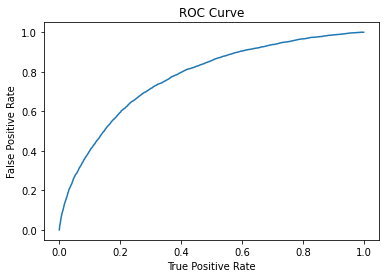

Training set ROC: 0.7722304910389057


In [ ]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7544057355839292


In [ ]:
from sklearn.metrics import confusion_matrix

y_predictions=predictions_LR.select("prediction").collect()
y_predictions_orig=predictions_LR.select("label").collect()

cm_1 = confusion_matrix(y_predictions_orig, y_predictions)
print("Confusion Matrix:")
print(cm_1)
acc_1 = evaluator.evaluate(predictions_LR)
 
print("Prediction Accuracy: ", acc_1)

Confusion Matrix:
[[20077    51]
 [ 1861    59]]
Prediction Accuracy:  0.7544067835643546


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")

dtc_model = dtc.fit(train)

pred = dtc_model.transform(test)
# pred.show(3)

In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8713354319680164
Confusion Matrix:
[[20127     1]
 [ 1920     0]]


In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.73061967211927


In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc = evaluator.evaluate(gbt_predictions)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.872668215272406


In [ ]:
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[20127     1]
 [ 1920     0]]


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from time import *
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
model = rf.fit(train)
rf_predictions = model.transform(test)

In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc_rf = evaluator.evaluate(rf_predictions)
 
print("Prediction Accuracy: ", acc_rf)


Prediction Accuracy:  0.8713580633012592


In [ ]:
y_pred=rf_predictions.select("prediction").collect()
y_orig=rf_predictions.select("label").collect()

cm_rf = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm_rf)

Confusion Matrix:
[[20128     0]
 [ 1920     0]]
